This notebook will try to answer a mixed bag of questions using recordings across three microphones (SMP1,7 and GRAS 1/4"), and angles. 

1. How stable is the playback of the speaker across time? [link](#q1)
    * These recordings have on-axis recordings with the GRAS mic. 
2. How much variation is there from one SMP mic to the other?
    * Comparison of sensitivity across different frequencies between SMP1 and 7. 

In [1]:
import dateutil

In [2]:
import datetime as dt
import dateutil
import glob
import matplotlib.pyplot as plt
import numpy as np 
import scipy.signal as signal 
import scipy.stats as stats
import soundfile as sf
from fullscale_calculations import * 

In [3]:
fs = 192000
dB = lambda X : 20*np.log10(abs(X))
dbrms = lambda X: dB(np.sqrt(np.mean(X**2.0)))
b,a = signal.butter(2,5000/fs*0.5,'high')
highpass = lambda X: signal.filtfilt(b,a,X)

In [4]:
print(f'Notebook cell run at : {dt.datetime.now()}')

Notebook cell run at : 2021-04-26 19:04:21.323024


In [5]:
%matplotlib notebook

<a id='q1'></a>
## How stable is the speaker playback across time?
The measurements were performed across about 1hour 15 mins. 

In [6]:
gras_files_onaxis = glob.glob('2021-04-22\\gras_gaindB_46_azimuth_angle_0_*')
gras_files_onaxis

['2021-04-22\\gras_gaindB_46_azimuth_angle_0_2021-04-22_14-57-04.wav',
 '2021-04-22\\gras_gaindB_46_azimuth_angle_0_2021-04-22_14-58-24.wav',
 '2021-04-22\\gras_gaindB_46_azimuth_angle_0_2021-04-22_14-58-54.wav',
 '2021-04-22\\gras_gaindB_46_azimuth_angle_0_2021-04-22_14-59-17.wav',
 '2021-04-22\\gras_gaindB_46_azimuth_angle_0_2021-04-22_14-59-39.wav',
 '2021-04-22\\gras_gaindB_46_azimuth_angle_0_2021-04-22_15-00-02.wav',
 '2021-04-22\\gras_gaindB_46_azimuth_angle_0_2021-04-22_16-06-49.wav',
 '2021-04-22\\gras_gaindB_46_azimuth_angle_0_2021-04-22_16-07-16.wav',
 '2021-04-22\\gras_gaindB_46_azimuth_angle_0_2021-04-22_16-14-08.wav']

<IPython.core.display.Javascript object>


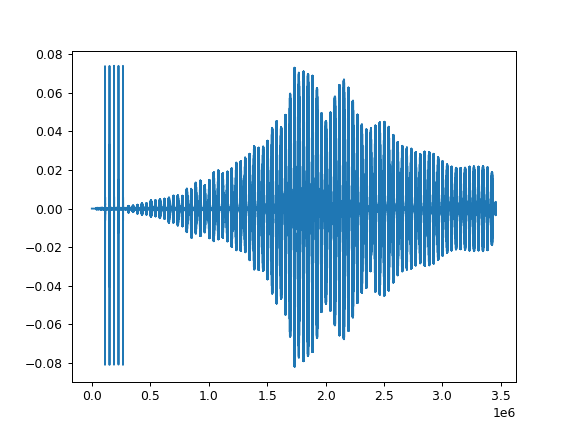

In [7]:
plt.figure()
plt.plot(sf.read(gras_files_onaxis[0])[0])

In [8]:
fs = 192000
half_durn = 9 # secs
half_durnsamples = int(half_durn*fs)
sweeps_section = int(1.5*fs)
audio_hp = []
tones_dbrms = []
audio_dbrms1half = []
audio_dbrms2half = []
sweeps_dbrms = []
silence_dbrms = []
tones_dbrms = []
for each in gras_files_onaxis:
    audio,fs = sf.read(each)
    highpassed = highpass(audio)
    audio_hp.append(highpassed)
    tones_dbrms.append(dbrms(highpassed[int(1.5*fs):]))
    audio_dbrms1half.append(dbrms(highpassed[int(1.5*fs):half_durnsamples]))
    audio_dbrms2half.append(dbrms(highpassed[half_durnsamples:]))
    sweeps_dbrms.append(dbrms(highpassed[int(0.5*fs):sweeps_section]))
    silence_dbrms.append(dbrms(highpassed[:int(0.5*fs)]))

In [9]:
datetimes_files = []
for each in gras_files_onaxis:
    timestamp = each[-23:-4]
    ymd, hhmmss = timestamp.split('_')
    fmted_ts = ymd + ' ' + hhmmss.replace('-',':')
    datetimes_files.append(dateutil.parser.parse(fmted_ts))

In [10]:
datetimes_files[0]

datetime.datetime(2021, 4, 22, 14, 57, 4)

In [11]:
time_since_start = [ (each-datetimes_files[0]).seconds/60.0 for each in datetimes_files] # minutes 

In [12]:
time_since_start[0] += 0.25 # just adding 1/4 a minute to help with visualisation -- THIS IS ACTUALLY 0 SECONDS WRT START!!

<IPython.core.display.Javascript object>


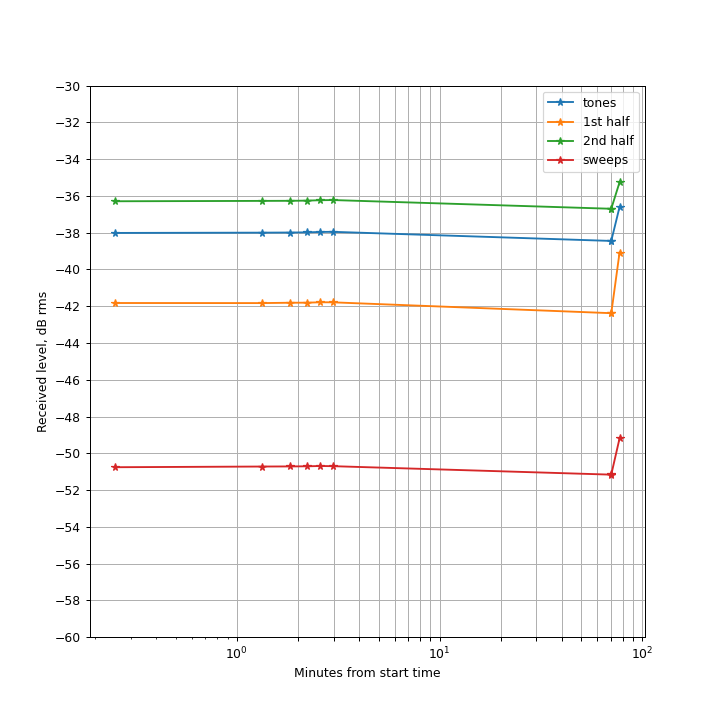

In [13]:
plt.figure(figsize=(8,8))
a0 = plt.subplot(111)
plt.plot(time_since_start, tones_dbrms,'-*',label='tones')
plt.plot(time_since_start, audio_dbrms1half,'-*',label='1st half')
plt.plot(time_since_start, audio_dbrms2half,'-*',label='2nd half')
plt.plot(time_since_start, sweeps_dbrms,'-*',label='sweeps')
#plt.xticks(range(len(wavfiles)),angles,rotation=60);
plt.legend()
plt.ylim(-60,-30);plt.yticks(np.arange(-60,-28,2));plt.grid()
plt.ylabel('Received level, dB rms');plt.xlabel('Minutes from start time');
a0.set_xscale('log');
plt.xticks(np.concatenate((np.arange(1,11), np.arange(20,110,10))));

In [14]:
diff_to_first = lambda X : X-X[0]

<IPython.core.display.Javascript object>


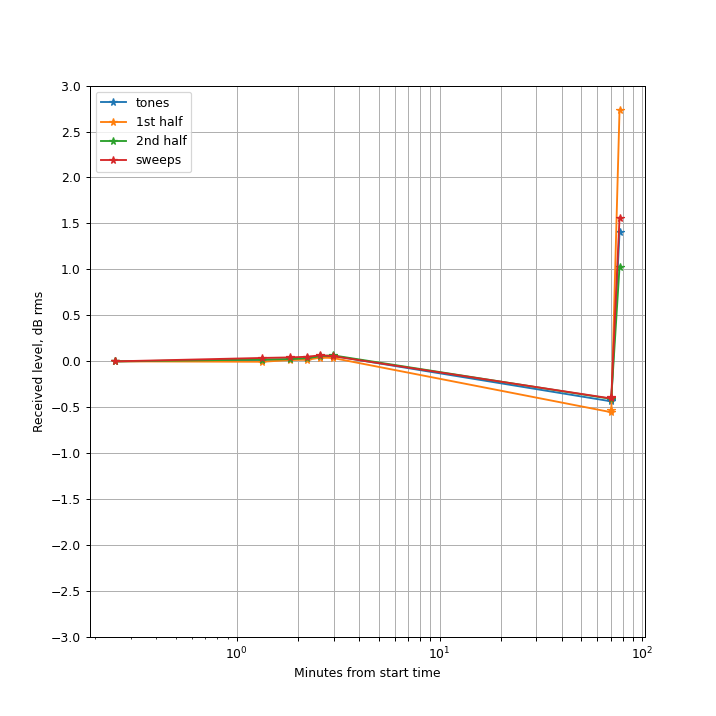

In [15]:
plt.figure(figsize=(8,8))
a0 = plt.subplot(111)
plt.plot(time_since_start, diff_to_first(tones_dbrms),'-*',label='tones')
plt.plot(time_since_start, diff_to_first(audio_dbrms1half),'-*',label='1st half')
plt.plot(time_since_start, diff_to_first(audio_dbrms2half),'-*',label='2nd half')
plt.plot(time_since_start, diff_to_first(sweeps_dbrms),'-*',label='sweeps')
#plt.xticks(range(len(wavfiles)),angles,rotation=60);
plt.legend()
plt.ylim(-3,3);plt.yticks(np.arange(-3,3.5,0.5));plt.grid()
plt.ylabel('Received level, dB rms');plt.xlabel('Minutes from start time');
a0.set_xscale('log');
plt.xticks(np.concatenate((np.arange(1,11), np.arange(20,110,10))));

### There is a weird jump of at least 1.5-2.5 dB in source level. The largest jump can be localised to the 1st half of the recording. Let's take a look using a power spectrum. 

 ### NEED TO TAKE A MORE DEEPER LOOK TO SEE WHERE THE OVERALL DIFFERENCE IS COMING FROM - THE SWEEPS OR THE TONES!!

In [16]:
first_audio, _ = sf.read(gras_files_onaxis[0])
last_audio, _ = sf.read(gras_files_onaxis[-1])
firstlast = [first_audio, last_audio]
power_spectra = [dB(np.fft.rfft(each)) for each in firstlast]
freqs = np.fft.rfftfreq(firstlast[0].size, 1/fs)

<IPython.core.display.Javascript object>


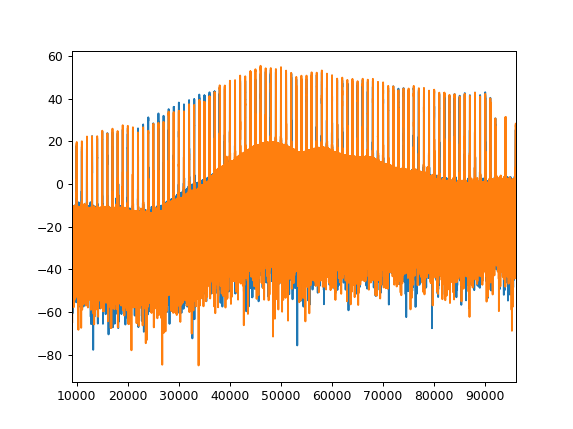

(9000.0, 96000.0)

In [17]:
plt.figure()
plt.plot(freqs,power_spectra[0])
plt.plot(freqs,power_spectra[1])
plt.xlim(9000, fs*0.5)